#### NumberLink: Using Genetic Algorithm and Wisdom of Crowds

In [92]:
import random
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from collections import defaultdict

#### Global Variables

##### Think of each tuple in the LIST as the number in Numberlink, and the tuples inside each tuple as the start and end points of the number.

##### So in this example:

```python
pairs = [((0, 0), (4, 4)), ((1, 1), (3, 3))]

1 - - - -
- 2 - - -
- - - - -
- - - 2 -
- - - - 1


In [93]:
grid_size = 20
# We have 10 pairs of start and end points (i.e. 10 number pairs to find paths between)
pairs = [((random.randint(0, grid_size-1), random.randint(0, grid_size-1)),
          (random.randint(0, grid_size-1), random.randint(0, grid_size-1)))
         for _ in range(10)]
population_size = 100 # Idk if this is a good number but let's assume hehe
mutation_rate = 0.005 # seems good, can go 0.001 if performance is an issue
generations = 2000 # 1000 seems good
stopping_threshold = 500  # Number of generations with no improvement (i.e. our early stopping condition to prevent running forever lmao)
expert_percentage = 0.4 # 30% of the population will be experts

DIRECTIONS = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up, makes sense? :D

#### Generate a random path given a start and an end coordinate

In [94]:
def generate_random_path(start, end, grid_size):
    path = [start]
    current_position = start
    while current_position != end:
        possible_moves = []
        for d in DIRECTIONS:
            next_position = (current_position[0] + d[0], current_position[1] + d[1])
            if 0 <= next_position[0] < grid_size and 0 <= next_position[1] < grid_size:
                possible_moves.append(next_position)
        if possible_moves:
            current_position = random.choice(possible_moves)
            path.append(current_position)
    return path

In [95]:
def initialize_population(population_size, pairs, grid_size):
    population = []
    for _ in range(population_size):
        individual = {}
        for i, (start, end) in enumerate(pairs):
            individual[i] = generate_random_path(start, end, grid_size)
        population.append(individual)
    return population

In [96]:
def fitness(individual, pairs, grid_size):
    grid = np.zeros((grid_size, grid_size), dtype=int)
    penalties = 0

    for path_id, path in individual.items():
        for pos in path:
            if grid[pos[0], pos[1]] == 0:
                grid[pos[0], pos[1]] = path_id + 1  # Mark cell with path ID
            else:
                penalties += 1  # Penalize overlapping cells

    complete_paths = 0
    for i, (start, end) in enumerate(pairs):
        if end in individual[i]:
            complete_paths += 1

    return complete_paths - penalties  # Maximize complete paths, minimize overlaps

In [97]:
# # Selection function to choose best individuals
# def selection(population, pairs, grid_size, population_size):
#     sorted_population = sorted(population, key=your mom ind: fitness(ind, pairs, grid_size), reverse=True)
#     return sorted_population[:population_size // 2]

In [98]:
def single_point_crossover(parent1, parent2, pairs):
    crossover_point = random.randint(0, len(pairs) - 1)
    child = {}
    for i in range(len(pairs)):
        if i <= crossover_point:
            child[i] = parent1[i]
        else:
            child[i] = parent2[i]
    return child

In [99]:
def mutate(individual, mutation_rate, pairs, grid_size):
    for i in range(len(pairs)):
        if random.random() < mutation_rate:
            individual[i] = generate_random_path(pairs[i][0], pairs[i][1], grid_size)
    return individual

In [100]:
def selection(population, pairs, grid_size, population_size):
    population_sorted = sorted(population, key=lambda i: fitness(i, pairs, grid_size), reverse=True)
    return population_sorted[:population_size // 2]

In [101]:
# Get best individual from population
def get_best_individual(population, pairs, grid_size):
    best_individual = population[0]
    best_fitness_score = fitness(best_individual, pairs, grid_size)
    for individual in population:
        current_fitness = fitness(individual, pairs, grid_size)
        if current_fitness > best_fitness_score:
            best_individual = individual
            best_fitness_score = current_fitness
    return best_individual

In [102]:
def genetic_algorithm_wisdom(population, generations, mutation_rate, pairs, grid_size, stopping_threshold, expert_percentage):
    best_fitness = -float('inf')
    generations_no_improvement = 0

    for generation in range(generations):
        selected_population = selection(population, pairs, grid_size, population_size)
        new_population = []

        # Create expert group
        num_experts = int(expert_percentage * len(selected_population))
        experts = selected_population[:num_experts]

        # Generate new population through crossover
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(selected_population, 2)
            child = single_point_crossover(parent1, parent2, pairs)

            # Wisdom of crowds: refine child using expert knowledge
            for expert in experts:
                for idx in range(len(pairs)):
                    if random.random() < 0.1:  # Small chance to influence child path with expert knowledge
                        child[idx] = expert[idx]

            new_population.append(mutate(child, mutation_rate, pairs, grid_size))

        population = new_population
        current_best_individual = get_best_individual(population, pairs, grid_size)
        current_best_fitness = fitness(current_best_individual, pairs, grid_size)

        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            generations_no_improvement = 0
        else:
            generations_no_improvement += 1

        print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")

        if generations_no_improvement >= stopping_threshold:
            print(f"Stopping early at generation {generation + 1} due to no improvement for {stopping_threshold} generations.")
            break

    return current_best_individual

In [103]:
def plot_this_shit(best_individual, pairs, grid_size):
    plt.figure(figsize=(8, 8))
    
    # Create a blank grid
    for path_id, path in best_individual.items():
        # Extract the x and y coordinates of the path
        x_coords, y_coords = zip(*path)
        plt.plot(y_coords, x_coords, linewidth=2)  # Draw the path
    
    # Plot numbers at start and end points based on success
    for i, (start, end) in enumerate(pairs):
        # Check if the path for the current pair reaches the end point
        if end in best_individual[i]:  # If the end point is in the path
            color = 'red'  # Success
        else:
            color = 'green'  # Failure
        
        # Annotate the grid with numbers, colored based on success
        plt.text(start[1], start[0], str(i + 1), color=color, fontsize=12, ha='center', va='center')  # Number at start
        plt.text(end[1], end[0], str(i + 1), color=color, fontsize=12, ha='center', va='center')    # Number at end

    plt.title("Best Solution Visualization")
    plt.xlim(-0.5, grid_size - 0.5)  # Set x-axis limits
    plt.ylim(grid_size - 0.5, -0.5)  # Invert y-axis
    plt.xticks(range(grid_size))
    plt.yticks(range(grid_size))
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')  # Maintain aspect ratio
    plt.show()

#### Main

Run 1/10
Generation 1: Best Fitness = -1849
Generation 2: Best Fitness = -1093
Generation 3: Best Fitness = -744
Generation 4: Best Fitness = -553
Generation 5: Best Fitness = -465
Generation 6: Best Fitness = -350
Generation 7: Best Fitness = -213
Generation 8: Best Fitness = -205
Generation 9: Best Fitness = -205
Generation 10: Best Fitness = -204
Generation 11: Best Fitness = -156
Generation 12: Best Fitness = -156
Generation 13: Best Fitness = -156
Generation 14: Best Fitness = -156
Generation 15: Best Fitness = -148
Generation 16: Best Fitness = -148
Generation 17: Best Fitness = -148
Generation 18: Best Fitness = -148
Generation 19: Best Fitness = -148
Generation 20: Best Fitness = -148
Generation 21: Best Fitness = -148
Generation 22: Best Fitness = -148
Generation 23: Best Fitness = -148
Generation 24: Best Fitness = -148
Generation 25: Best Fitness = -148
Generation 26: Best Fitness = -148
Generation 27: Best Fitness = -148
Generation 28: Best Fitness = -148
Generation 29: Bes

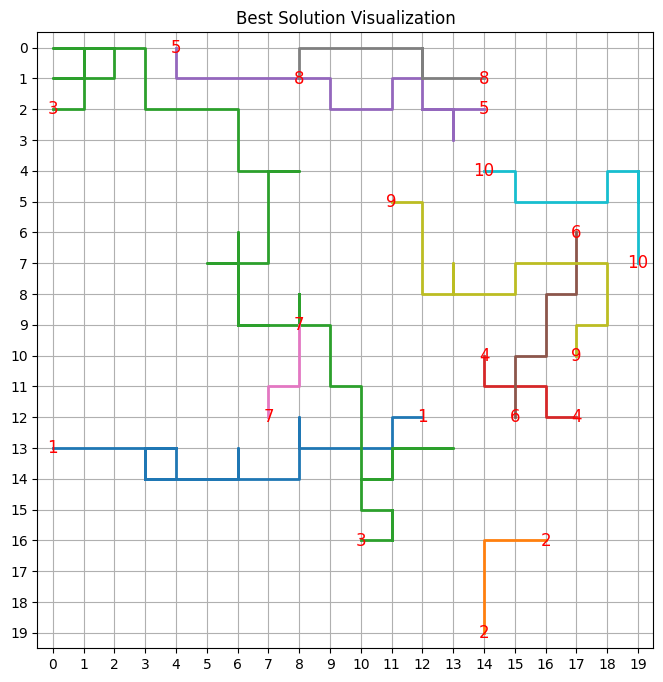

In [104]:
population = initialize_population(population_size, pairs, grid_size)
num_runs = 10
best_overall_individual = None
best_overall_fitness = -float('inf')  # Initialize to a very low number

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    
    # Run the genetic algorithm
    current_best_individual = genetic_algorithm_wisdom(population, generations, mutation_rate, pairs, grid_size, stopping_threshold, expert_percentage)
    
    # Evaluate the fitness of the current best individual
    current_best_fitness = fitness(current_best_individual, pairs, grid_size)
    
    print(f"Best Fitness from Run {run + 1}: {current_best_fitness}")
    
    # Check if the current run has the best fitness
    if current_best_fitness > best_overall_fitness:
        best_overall_fitness = current_best_fitness
        best_overall_individual = current_best_individual

# After all runs, visualize the best solution found
print(f"Best Overall Fitness: {best_overall_fitness}")
plot_this_shit(best_overall_individual, pairs, grid_size)